# Neural Translator from English to Russian

In case of using RNN we always get one hidden state per input and that always translates to one output per input. If we keep all the outputs at each point in time, we would get output length equal to input length. Here we can clearly see the problem: most certantly the translation will contain different number of words, than the input sentence. 

Solution would be using dual RNN or **seq2seq** architecture. First RNN, that takes the input is called **Encoder**, and the second, that produces translation, is called **Decoder**. Encoder takes in some raw input, like text, audio or image, and create some vector representation out of it. Then, the Decoder produces new data from this compressed vector representation. Such type of architecture can be used for any kind of request/response type of task.

Encoder returns just final hidden state, thus from entire input sequence we end up with static size M vector, where M is the number of RNN units in the RNN layer. This final hidden state is called a **thought vector**. So, Encoder's job is to fold up the input sequence into small, but informative vector and Decoder's job is to unfold this vector into a new sequence.

For training Decoder we would need to user **teacher forcing**, where we pass true target sequence with offset. During predictions we would use the output of previous LSTM as the input to the next one, but for training we need to feed in the true word, even when predictions of previous LSTM is incorrect. This is, basically, how human learns a language: it's better to correct the wrong use of particular word, or all future words, most probably, would be incorrect.

## 1. Loading data

We would split our initial dataset with a lot of translated words and phrases into input sequence for Encoder, input sequence for Decoder and target sequence for Decoder.

In [53]:
# constants
BATCH_SIZE = 64
LATENT_DIM = 256
EPOCHS = 40
MAX_NUM_WORDS = 20000
NUM_SAMPLES = 10000
EMBEDDING_DIM = 100

input_texts = []
target_texts = []
target_texts_input = []

t = 0
for line in open('rus.txt', encoding='utf-8'):
    # limiting dataset
    t += 1
    if t > NUM_SAMPLES:
        break

    input_text, translation, *rest = line.rstrip().split('\t')
    target_text = translation + ' <eos>'
    target_text_input = '<sos> ' + translation
    input_texts.append(input_text)
    target_texts.append(target_text)
    target_texts_input.append(target_text_input)
print(f'Number of input sentences: {len(input_texts)}')

Number of input sentences: 10000


In [54]:
import numpy as np

random_idx = np.random.choice(len(input_texts))
print(input_texts[random_idx])
print(target_texts_input[random_idx])
print(target_texts[random_idx])

OK. Go ahead.
<sos> Ладно, давай.
Ладно, давай. <eos>


Now, it's time to convert or sentences in sequences of numbers with the use of Keras' Tokenizer. We would need to create two separate tokenizer, as we're dealing with 2 different languages.

In [55]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(input_texts)
input_sequences = tokenizer.texts_to_sequences(input_texts)

word2idx_input = tokenizer.word_index
print(f'Found {len(word2idx_input)} unique words in english language.')

print(input_sequences[random_idx])

max_len_input = max(len(s) for s in input_sequences)

Found 1731 unique words in english language.
[81, 9, 417]


In [56]:
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS,filters='')
tokenizer.fit_on_texts(target_texts+target_texts_input) # inefficient way to find <eos>
target_sequences = tokenizer.texts_to_sequences(target_texts)
target_sequences_input = tokenizer.texts_to_sequences(target_texts_input)

word2idx_output = tokenizer.word_index
print(f'Found {len(word2idx_output)} unique words in Russian language.')

print(target_sequences[random_idx])
print(target_sequences_input[random_idx])

num_words_output = len(word2idx_output) + 1
max_len_target = max(len(s) for s in target_sequences)

Found 5923 unique words in Russian language.
[217, 2365, 1]
[2, 217, 2365]


We've find the max length of the sequence, because every input must have the same length. We're going to use this values to padd all sequences.

In [57]:
from keras.preprocessing.sequence import pad_sequences

encoder_inputs = pad_sequences(input_sequences, maxlen=max_len_input)
print(f'encoder_inputs.shape: {encoder_inputs.shape}')
print(encoder_inputs[random_idx])

decoder_inputs = pad_sequences(target_sequences_input, maxlen=max_len_target, padding='post')
print(f'decoder_inputs.shape: {decoder_inputs.shape}')
print(decoder_inputs[random_idx])

decoder_targets = pad_sequences(target_sequences, maxlen=max_len_target, padding='post')

encoder_inputs.shape: (10000, 5)
[  0   0  81   9 417]
decoder_inputs.shape: (10000, 11)
[   2  217 2365    0    0    0    0    0    0    0    0]


For the Encoder we're going to use pre-trained with GloVe word embeddings. Let's load them and store them in the embedding matrix. This will help us to set the embedding layer, making use of good hyperparameters found by others. We're not going to train this layer, because the number of uncommon words i small and their effect is small.

In [58]:
word2vec = {}
for line in open(f'glove.6B.{EMBEDDING_DIM}d.txt', encoding='utf-8'):
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:],dtype='float32')
    word2vec[word] = vec
print(f'Found {len(word2vec)} word vectors')

num_words = min(MAX_NUM_WORDS, len(word2idx_input) + 1)
embedding_matrix = np.zeros((num_words,EMBEDDING_DIM))
for word,i in word2idx_input.items():
    if i < MAX_NUM_WORDS:
        embedding_vector = word2vec.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
print(f'embedding_matrix.shape {embedding_matrix.shape}')

Found 400000 word vectors
embedding_matrix.shape (1732, 100)


In [59]:
from keras.layers import Input, LSTM, GRU, Dense, Embedding

embedding_layer = Embedding(
    num_words,
    EMBEDDING_DIM,
    weights=[embedding_matrix],
    input_length=max_len_input
)

# in our model we will not be able to use sparce_categorical_crossentropy
# thus we need to create OHE labels
decoder_target_one_hot = np.zeros(
    (
        len(input_sequences),
        max_len_target,
        num_words_output
    ),
    dtype='float32'
)

for i,target_sequence in enumerate(decoder_targets):
    for t,word in enumerate(target_sequence):
        if word != 0:
            decoder_target_one_hot[i,t,word] = 1
print(f'decoder_target_one_hot.shape: {decoder_target_one_hot.shape}')

decoder_target_one_hot.shape: (10000, 11, 5924)


Now, it's time to create the model. The first is Encoder, which is going to take the input sequence in English, pass it through the embedding layer with pre-trained weights and then to the layer with LSTMs. We will need to make this layer to return state, as we will need it for the Decoder.

In [60]:
encoder_input_placeholder = Input(shape=(max_len_input,))
x = embedding_layer(encoder_input_placeholder)
encoder = LSTM(LATENT_DIM,return_state=True)
encoder_outputs, h, c = encoder(x)
# states to pass into Decoder
encoder_states = [h,c]

Decoder's turn

In [61]:
from __future__ import print_function, division
from builtins import range, input

from keras.models import Model
from keras.layers import Input, LSTM, GRU, Dense, Embedding
import matplotlib.pyplot as plt

try:
    import keras.backend as K
    if len(K.tensorflow_backend._get_available_gpus()) > 0:
        from keras.layers import CuDNNLSTM as LSTM
        from keras.layers import CuDNNGRU as GRU
except:
    pass

decoder_input_placeholder = Input(shape=(max_len_target,))
embedding_decoder = Embedding(num_words_output,EMBEDDING_DIM)
decoder_input_x = embedding_decoder(decoder_input_placeholder)
decoder_lstm = LSTM(LATENT_DIM, return_state=True, return_sequences=True)
decoder_outputs, _, _ = decoder_lstm(decoder_input_x, initial_state=encoder_states)
decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)
model = Model([encoder_input_placeholder,decoder_input_placeholder], decoder_outputs)

def custom_loss(y_true, y_pred):
    # both are of shape N x T x K
    mask = K.cast(y_true > 0, dtype='float32')
    out = mask * y_true * K.log(y_pred)
    return -K.sum(out) / K.sum(mask)


def acc(y_true, y_pred):
    # both are of shape N x T x K
    targ = K.argmax(y_true, axis=-1)
    pred = K.argmax(y_pred, axis=-1)
    correct = K.cast(K.equal(targ, pred), dtype='float32')

    # 0 is padding, don't include those
    mask = K.cast(K.greater(targ, 0), dtype='float32')
    n_correct = K.sum(mask * correct)
    n_total = K.sum(mask)
    return n_correct / n_total

model.compile(optimizer='adam', loss=custom_loss, metrics=[acc])

r = model.fit([encoder_inputs,decoder_inputs], decoder_target_one_hot, batch_size=BATCH_SIZE, epochs=EPOCHS,validation_split=.2)

Train on 8000 samples, validate on 2000 samples
Epoch 1/40
8000/8000 [==============================] - 49s 6ms/step - loss: 5.5877 - acc: 0.3569 - val_loss: 5.3442 - val_acc: 0.3002
Epoch 2/40
8000/8000 [==============================] - 43s 5ms/step - loss: 4.5640 - acc: 0.3809 - val_loss: 5.1896 - val_acc: 0.3182
Epoch 3/40
8000/8000 [==============================] - 45s 6ms/step - loss: 4.1879 - acc: 0.4024 - val_loss: 5.0528 - val_acc: 0.3689
Epoch 4/40
8000/8000 [==============================] - 46s 6ms/step - loss: 3.8832 - acc: 0.4306 - val_loss: 4.9032 - val_acc: 0.3945
Epoch 5/40
8000/8000 [==============================] - 46s 6ms/step - loss: 3.6299 - acc: 0.4528 - val_loss: 4.8507 - val_acc: 0.4202
Epoch 6/40
8000/8000 [==============================] - 50s 6ms/step - loss: 3.4132 - acc: 0.4741 - val_loss: 4.7764 - val_acc: 0.4362
Epoch 7/40
8000/8000 [==============================] - 53s 7ms/step - loss: 3.2141 - acc: 0.4883 - val_loss: 4.7650 - val_acc: 0.4451
Epoch 8

In [62]:
model.save('s2s.h5')

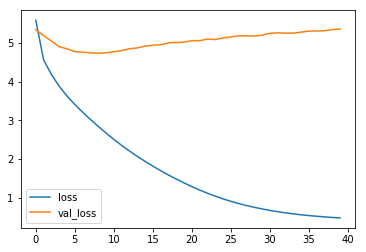

In [63]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

For prediction we need to create another model with the use of previously trained layers.

In [66]:
encoder_model = Model(encoder_input_placeholder, encoder_states)

decoder_state_input_h = Input(shape=(LATENT_DIM,))
decoder_state_input_c = Input(shape=(LATENT_DIM,))
decoder_states_input = [decoder_state_input_h, decoder_state_input_c]

decoder_input_single = Input(shape=(1,))
decoder_input_single_x = embedding_decoder(decoder_input_single)
decoder_outputs, h, c = decoder_lstm(decoder_input_single_x,initial_state=decoder_states_input)

decoder_states = [h,c]

decoder_outputs = decoder_dense(decoder_outputs)

decoder_model = Model([decoder_input_single] + decoder_states_input, [decoder_outputs] + decoder_states)

We need to map back from word index into the word itself.

In [67]:
idx2word_eng = {v:k for k,v in word2idx_input.items()}
idx2word_rus = {v:k for k,v in word2idx_output.items()}

In [73]:
def decode_sequence(input_seq):
  # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

  # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1))

  # Populate the first character of target sequence with the start character.
  # NOTE: tokenizer lower-cases all words
    target_seq[0, 0] = word2idx_output['<sos>']

  # if we get this we break
    eos = word2idx_output['<eos>']

  # Create the translation
    output_sentence = []
    for _ in range(max_len_target):
        output_tokens, h, c = decoder_model.predict(
          [target_seq] + states_value
        )
    # output_tokens, h = decoder_model.predict(
    #     [target_seq] + states_value
    # ) # gru

    # Get next word
        idx = np.argmax(output_tokens[0, 0, :])

    # End sentence of EOS
        if eos == idx:
            break

        word = ''
        if idx > 0:
            word = idx2word_rus[idx]
            output_sentence.append(word)

    # Update the decoder input
    # which is just the word just generated
        target_seq[0, 0] = idx
 
    # Update states
        states_value = [h, c]
    # states_value = [h] # gru

    return ' '.join(output_sentence)

In [74]:
while True:
  # Do some test translations
    i = np.random.choice(len(input_texts))
    input_seq = encoder_inputs[i:i+1]
    translation = decode_sequence(input_seq)
    print('-')
    print('Input:', input_texts[i])
    print('Translation:', translation)

    ans = input("Continue? [Y/n]")
    if ans and ans.lower().startswith('n'):
        break

-
Input: I'm with him.
Translation: я с ним.
Continue? [Y/n]y
-
Input: Are you up?
Translation: ты встал?
Continue? [Y/n]y
-
Input: Take a nap.
Translation: вздремните.
Continue? [Y/n]y
-
Input: He gave up.
Translation: он сдался.
Continue? [Y/n]n
